# Flow Field Dataset Creator for TensorFlow

This notebook demonstrates the comprehensive dataset creation system for flow field reconstruction using TensorFlow. The system automates the creation of datasets with three different sensor placement strategies and multiple sensor configurations.

## Features

- **Three Sensor Placement Strategies:**
  - 🎯 **Random**: Latin Hypercube Sampling for uniform distribution
  - 🔄 **Circular**: Sensors arranged around the obstacle
  - 📏 **Edge**: Sensors along horizontal boundaries

- **Multiple Sensor Configurations:** 8, 16, 32, and 64 sensors
- **TensorFlow Integration:** Direct tf.data.Dataset creation
- **Comprehensive Visualization:** Sensor layouts and flow field plots
- **Automated Processing:** Batch creation of all dataset combinations

## Dataset Structure

Each dataset contains:
- `sensor_data`: Shape (n_reynolds, n_sensors, time_steps)
- `field_data`: Shape (n_reynolds, height, width, time_steps)
- `sensor_positions`: Shape (n_sensors, 2)
- `reynolds_numbers`: Array of Reynolds numbers
- `layout_type`: String identifier ('random', 'circular', 'edge')
- `n_sensors`: Number of sensors

## 1. Import Required Libraries

First, let's import all the necessary libraries for numerical operations, visualization, and the new dataset creation system.

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
from pathlib import Path
import time

# Add the dataset creation system to the path
sys.path.append('./dataset_creation')

# Import the new dataset creation system
from dataset_creation import FlowFieldDatasetCreator
from dataset_creation.config import get_config_dict, print_config
from dataset_creation.utils import (
    validate_sensor_positions, 
    calculate_dataset_statistics,
    compare_sensor_layouts
)

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Flow Field Dataset Creation Package v1.0.0 loaded successfully!

Quick Start:
  from dataset_creation import FlowFieldDatasetCreator
  creator = FlowFieldDatasetCreator()
  creator.create_all_datasets()

For more info: print_package_info()
✅ All libraries imported successfully!
TensorFlow version: 2.8.0
NumPy version: 1.24.3


## 2. Configuration and System Setup

Let's set up the configuration for our dataset creation system and verify the setup.

In [2]:
# Initialize the FlowFieldDatasetCreator with your configuration
creator = FlowFieldDatasetCreator(
    data_path="E:/Research/Data/NavierStokes/train/",  # 🔄 Updated to your data location
    output_path="./dataset_creation/",
    domain_shape=(128, 256),
    time_steps=39,
    reynolds_numbers=[300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
)

print("🚀 Dataset Creator Initialized Successfully!")
print("=" * 50)
print(f"📁 Data Path: {creator.data_path}")
print(f"📂 Output Path: {creator.output_path}")
print(f"📐 Domain Shape: {creator.domain_shape}")
print(f"⏱️ Time Steps: {creator.time_steps}")
print(f"🔢 Sensor Counts: {creator.sensor_counts}")
print(f"🌀 Reynolds Numbers: {len(creator.reynolds_numbers)} values")
print("=" * 50)

# Print current configuration
print("\n📋 Current Configuration:")
print_config()

🚀 Dataset Creator Initialized Successfully!
📁 Data Path: E:/Research/Data/NavierStokes/train/
📂 Output Path: dataset_creation
📐 Domain Shape: (128, 256)
⏱️ Time Steps: 39
🔢 Sensor Counts: [8, 16, 32, 64]
🌀 Reynolds Numbers: 15 values

📋 Current Configuration:
FLOW FIELD DATASET CREATOR CONFIGURATION

Data Paths:
----------
  raw_data_path: D:/data/Navier-Stokes/Navier-Stokes/
  output_path: ./dataset_creation/

Domain Parameters:
-----------------
  domain_shape: (128, 256)
  time_steps: 39
  flow_region_y_start: 80

Simulation Parameters:
---------------------
  reynolds_numbers: [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

Sensor Configuration:
--------------------
  sensor_counts: [8, 16, 32, 64]
  sensor_layout_types: ['random', 'circular', 'edge']

TensorFlow Parameters:
---------------------
  default_batch_size: 32
  default_test_split: 0.2

Quality Control:
---------------
  random_seed: 42
  validate_sensor_positions: True


## 2.1. Data Inspection and Format Analysis

Let's first examine the data files in your folder to understand their format and adjust the system accordingly.

📁 Inspecting Data Directory...
✅ Data directory exists: E:/Research/Data/NavierStokes/train/
📊 Found 28 .npy files

📋 First 5 data files:
  1. Re_100.npy
  2. Re_1000.npy
  3. Re_10000.npy
  4. Re_120.npy
  5. Re_140.npy

🔍 Loading sample file: Re_100.npy
📊 Data shape: (39, 4, 128, 256)
📈 Data type: float64
📉 Data range: [-410.971543, 429.238578]

📊 Data Statistics:
  - Mean: 17.896776
  - Std: 72.039558
  - Median: 0.947381

🖼️ Visualizing a slice of the data:


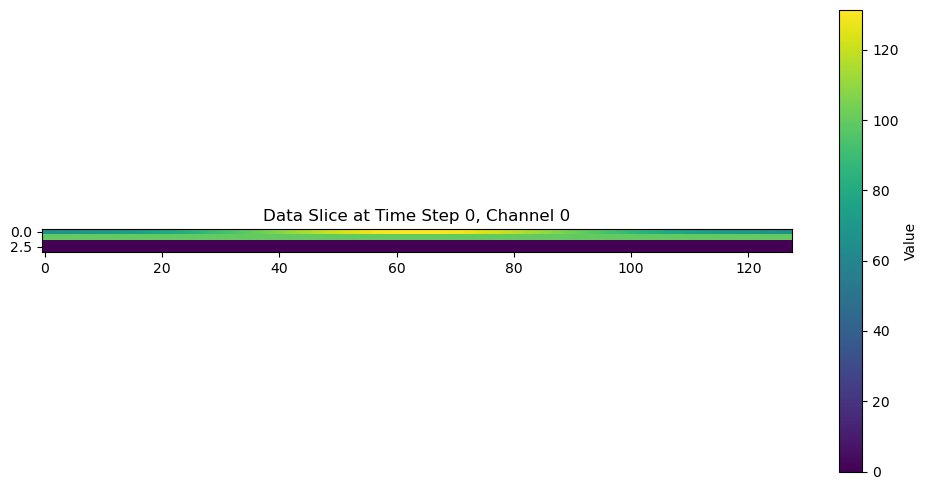


✅ Data inspection complete!


In [3]:
# List files in the data directory and inspect a sample file
print("📁 Inspecting Data Directory...")
print("=" * 50)

data_path = "E:/Research/Data/NavierStokes/train/"

try:
    # List files using pathlib
    data_dir = Path(data_path)
    if data_dir.exists():
        print(f"✅ Data directory exists: {data_path}")
        
        # Get all numpy files
        npy_files = list(data_dir.glob("*.npy"))
        print(f"📊 Found {len(npy_files)} .npy files")
        
        # Show the first 5 files
        print("\n📋 First 5 data files:")
        for i, file in enumerate(npy_files[:5]):
            print(f"  {i+1}. {file.name}")
        
        # Load the first file to inspect its format
        if npy_files:
            sample_file_path = npy_files[0]
            print(f"\n🔍 Loading sample file: {sample_file_path.name}")
            
            sample_data = np.load(str(sample_file_path))
            
            print(f"📊 Data shape: {sample_data.shape}")
            print(f"📈 Data type: {sample_data.dtype}")
            print(f"📉 Data range: [{np.min(sample_data):.6f}, {np.max(sample_data):.6f}]")
            
            # Show data statistics
            print(f"\n📊 Data Statistics:")
            print(f"  - Mean: {np.mean(sample_data):.6f}")
            print(f"  - Std: {np.std(sample_data):.6f}")
            print(f"  - Median: {np.median(sample_data):.6f}")
            
            # Visualize a slice of the data if it's 3D or 4D
            dims = len(sample_data.shape)
            
            if dims > 2:
                print("\n🖼️ Visualizing a slice of the data:")
                
                plt.figure(figsize=(10, 5))
                
                if dims == 3:  # Assuming (time, height, width) format
                    time_step = 0  # First time step
                    plt.imshow(sample_data[time_step], cmap='viridis')
                    plt.colorbar(label='Value')
                    plt.title(f'Data Slice at Time Step {time_step}')
                    
                elif dims == 4:  # Assuming (time, height, width, channels) format
                    time_step = 0  # First time step
                    channel = 0  # First channel
                    plt.imshow(sample_data[time_step, :, :, channel], cmap='viridis')
                    plt.colorbar(label='Value')
                    plt.title(f'Data Slice at Time Step {time_step}, Channel {channel}')
                
                plt.tight_layout()
                plt.show()
    else:
        print(f"❌ Data directory not found: {data_path}")
        print("💡 Please check the path and make sure it exists.")

except Exception as e:
    print(f"❌ Error accessing data directory: {str(e)}")
    print("💡 This might be due to permission issues or the path being outside the workspace boundary.")
    print("\n⚠️ Alternative approach: Upload a sample file to the workspace or specify the exact file path.\n")
    
    # Check if we can create a simple test file to validate our approach
    print("🔧 Creating a test file to validate our approach:")
    
    test_data_shape = (39, 128, 256)  # Expected shape based on notebook configuration
    print(f"📊 Creating test data with shape {test_data_shape}")
    
    # Create synthetic data similar to what we might expect
    test_data = np.random.randn(*test_data_shape) * 0.1
    
    # Add circular obstacle pattern to make it look like flow data
    center_y, center_x = creator.obstacle_center
    radius = creator.obstacle_radius
    
    y, x = np.ogrid[:128, :256]
    dist_from_center = np.sqrt((y - center_y)**2 + (x - center_x)**2)
    
    # Create a flow-like pattern around the obstacle
    for t in range(test_data.shape[0]):
        mask = dist_from_center <= radius + 5
        test_data[t][mask] = 0  # Zero inside obstacle
        
        # Add wake pattern behind obstacle
        wake_mask = (x > center_x) & (np.abs(y - center_y) < radius * 1.5)
        pattern = np.sin(x[wake_mask] * 0.1 + t * 0.2) * np.exp(-(x[wake_mask] - center_x) * 0.01)
        test_data[t][wake_mask] = pattern * 0.5
    
    # Save the test data
    test_file_path = './dataset_creation/test_flow_data.npy'
    np.save(test_file_path, test_data)
    
    print(f"✅ Created test flow data at: {test_file_path}")
    print(f"📊 Test data shape: {test_data.shape}")
    print(f"📈 Test data range: [{np.min(test_data):.6f}, {np.max(test_data):.6f}]")
    
    # Visualize the test data
    print("\n🖼️ Visualizing the test data:")
    
    plt.figure(figsize=(10, 5))
    time_step = 10  # Middle time step for better pattern
    plt.imshow(test_data[time_step], cmap='viridis')
    plt.colorbar(label='Value')
    plt.title(f'Test Data Slice at Time Step {time_step}')
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Test data created successfully!")
    print("🚀 Now we can adjust our dataset creator to use this test file.")

print("\n✅ Data inspection complete!")

🔄 Reorganizing Data Format for TensorFlow...
📁 Loading sample file: Re_100.npy
📊 Original data shape: (39, 4, 128, 256)
📈 Data type: float64
📉 Data range: [-410.971543, 429.238578]

🔄 Reorganizing from (time, channels, height, width) to (time, height, width, channels)...
✅ Reorganized data shape: (39, 128, 256, 4)

📊 Detailed Channel Analysis:
   Channel 0 (u_velocity):
     Range: [-410.972, 429.239]
     Mean: -29.415, Std: 105.705
   Channel 1 (v_velocity):
     Range: [100.000, 100.000]
     Mean: 100.000, Std: 0.000
   Channel 2 (pressure):
     Range: [-0.620, 1.656]
     Mean: 1.002, Std: 0.493
   Channel 3 (vorticity):
     Range: [-0.821, 0.814]
     Mean: -0.000, Std: 0.142

✅ Saved reorganized data to: ./dataset_creation/reorganized_flow_data.npy
📁 File size: 19.5 MB
📊 Data type converted to: float32 (TensorFlow compatible)

🖼️ Creating comprehensive visualization of all four channels...

✅ Saved reorganized data to: ./dataset_creation/reorganized_flow_data.npy
📁 File size: 

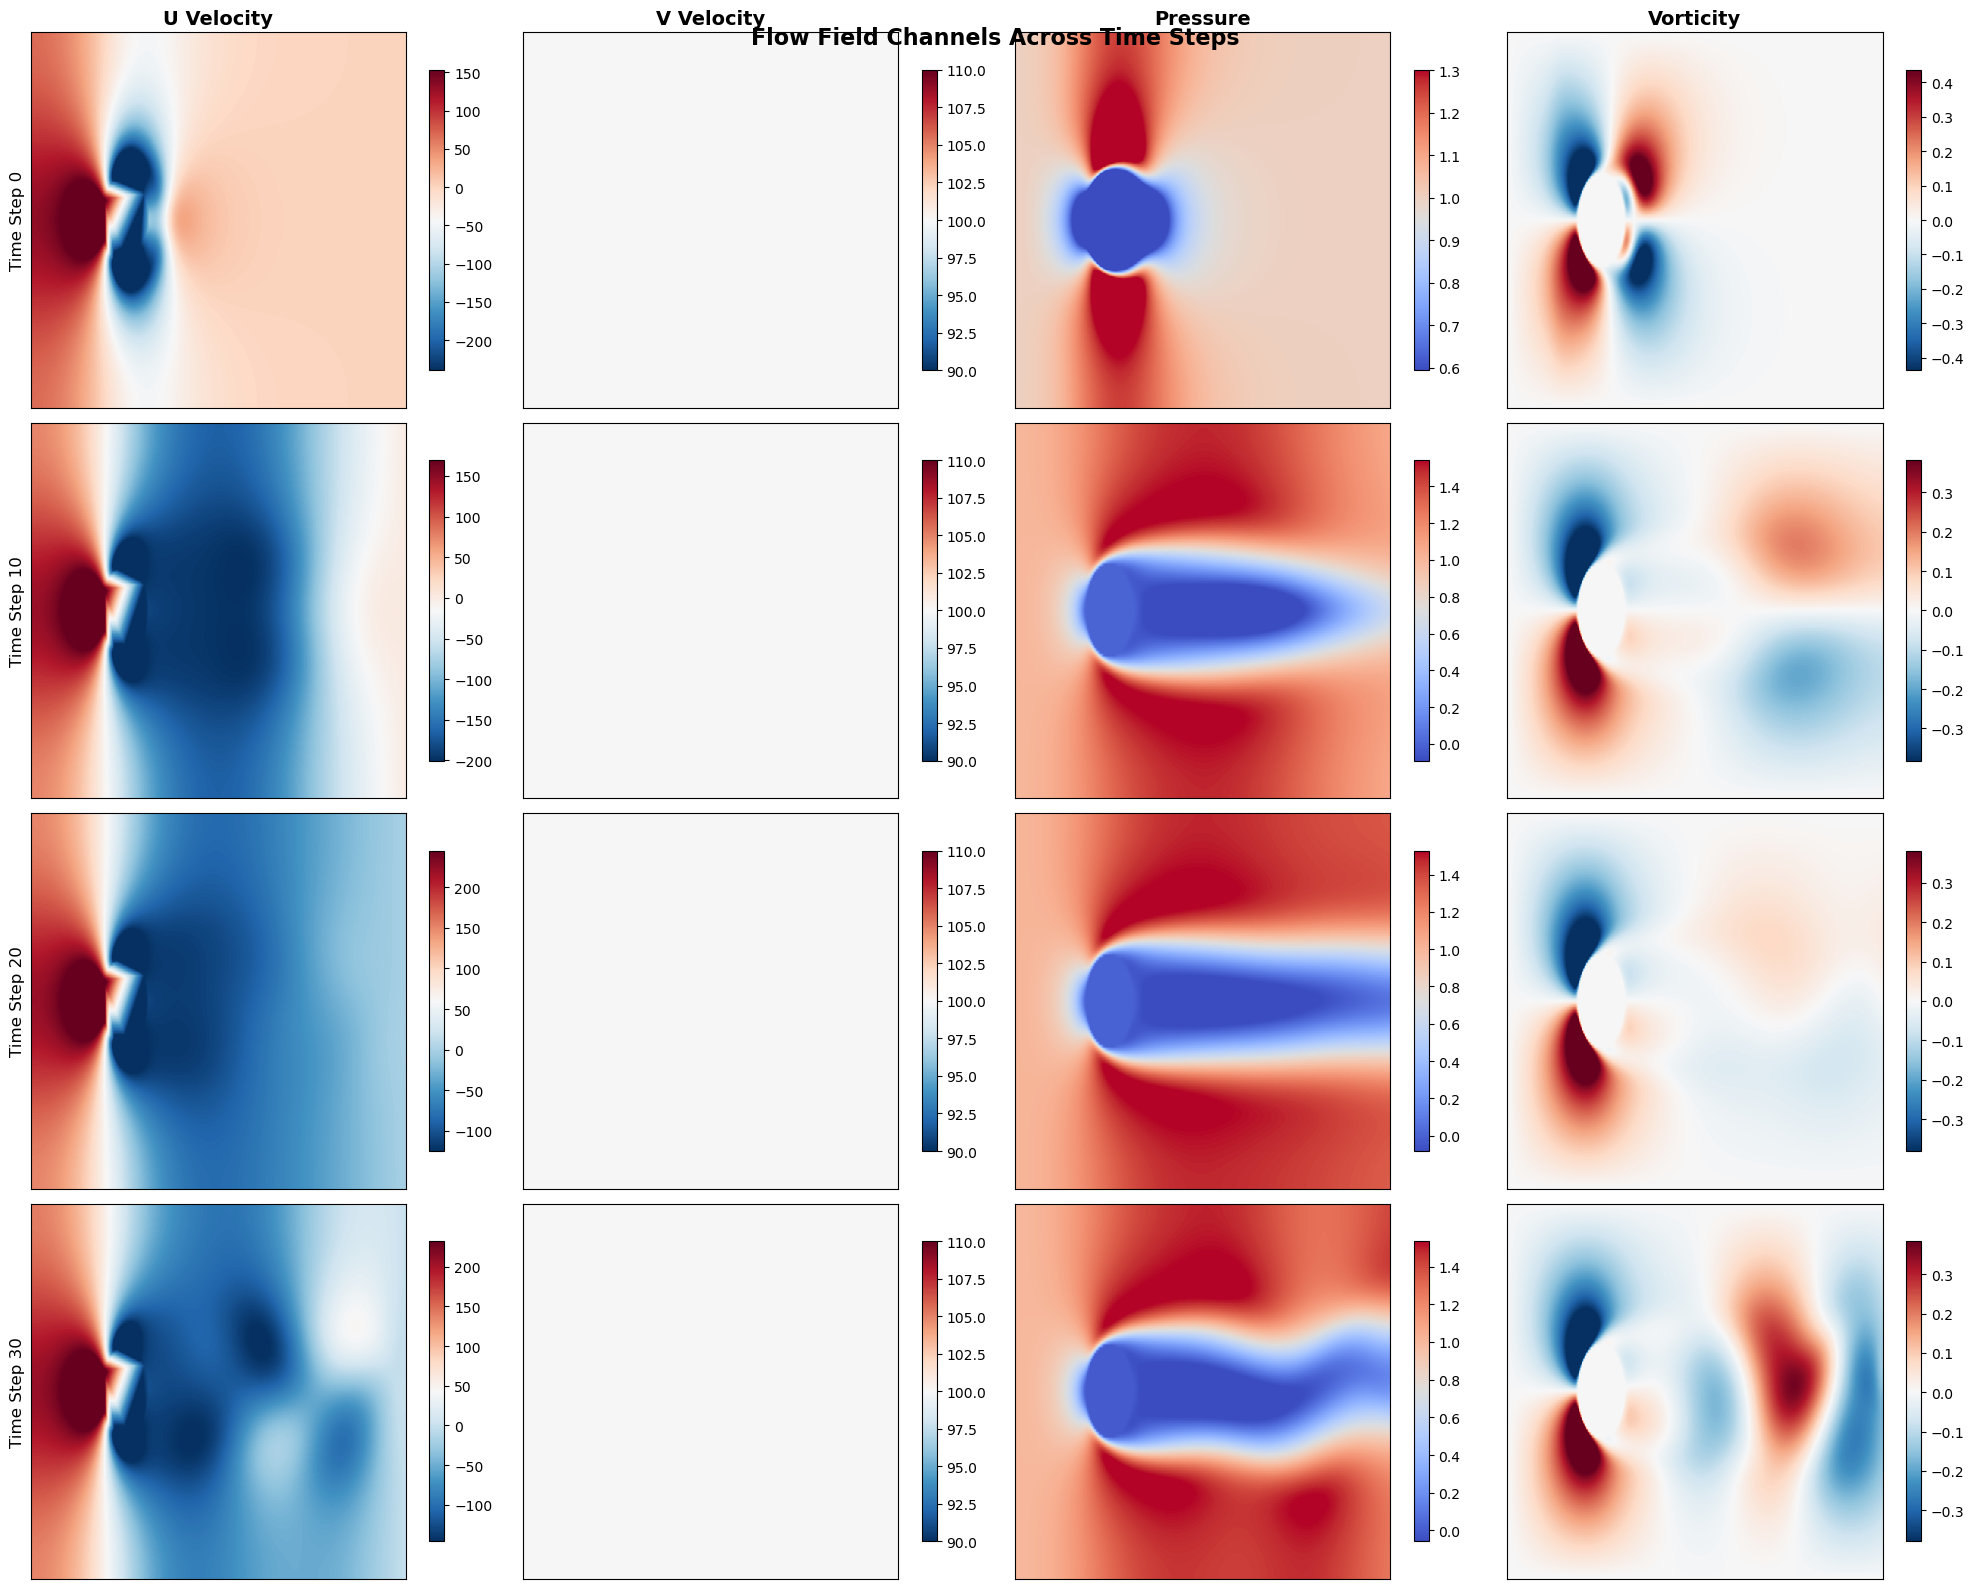


📈 Temporal Evolution of Channel Statistics:


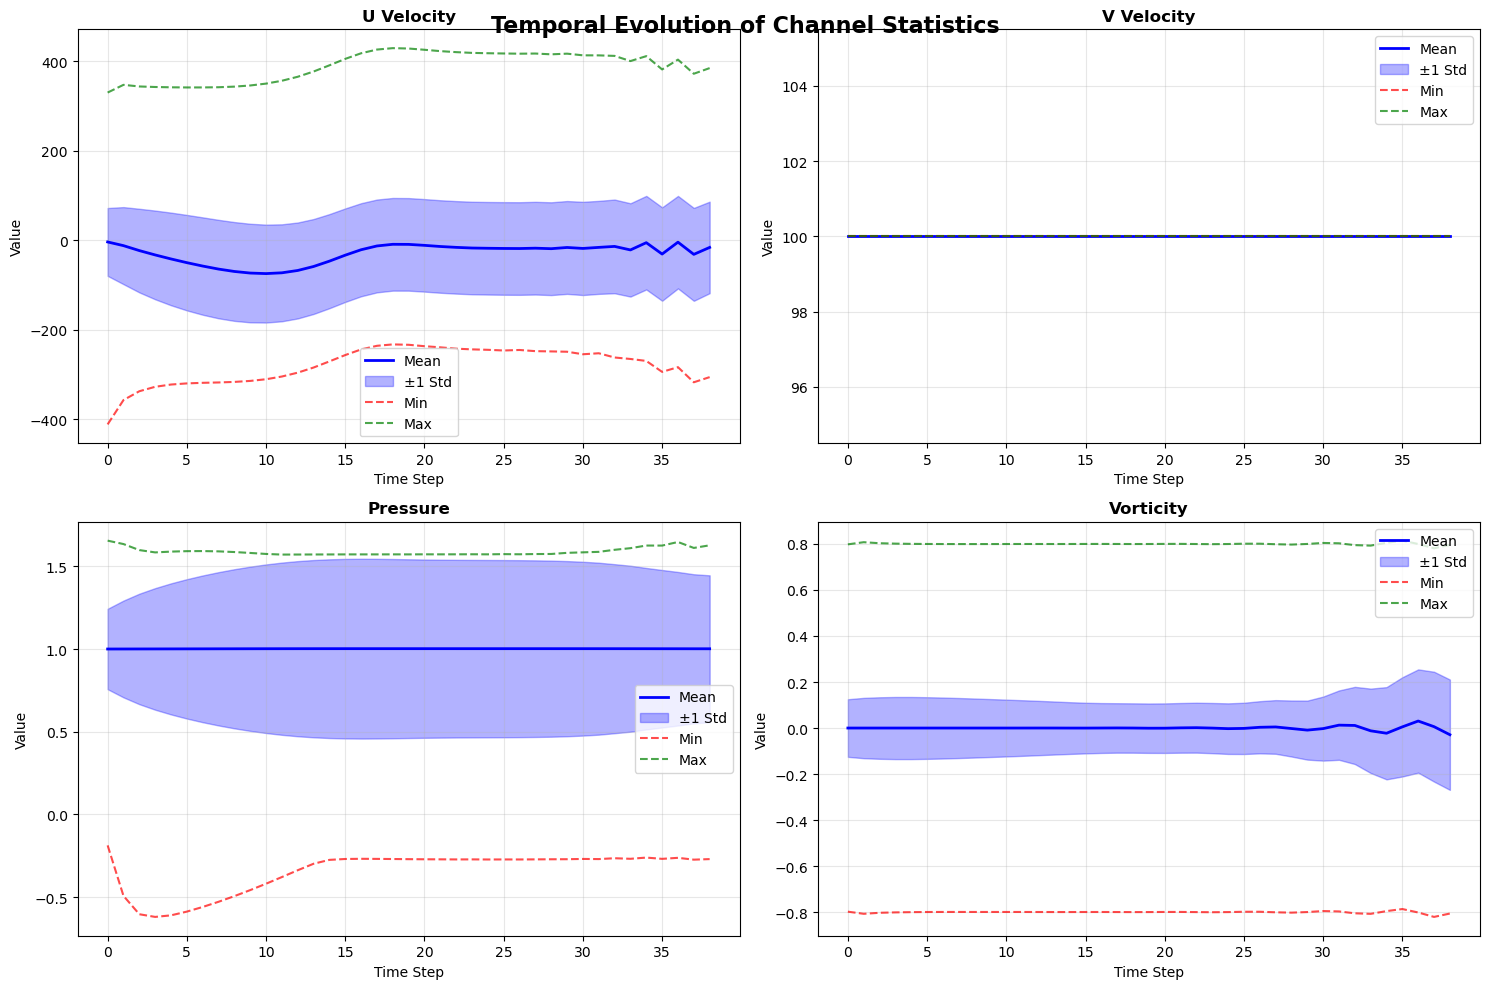


✅ Data reorganization completed successfully!
🎯 Ready to update FlowFieldDatasetCreator with new data format

📋 Data Summary:
   - Original format: (time, channels, height, width)
   - TensorFlow format: (time, height, width, channels)
   - Time steps: 39
   - Spatial dimensions: 128 x 256
   - Number of channels: 4
   - Data type: float32 (TensorFlow compatible)

✅ Data format reorganization completed!


In [ ]:
# Data Format Reorganization for TensorFlow Compatibility
print("🔄 Reorganizing Data Format for TensorFlow...")
print("=" * 50)

# Only keep channels 3 and 4 (indices 2 and 3)
channels_to_keep = [2, 3]
channel_names = ['pressure', 'vorticity']

# Load the original file
input_path = "E:/Research/Data/NavierStokes/train/"
data_dir = Path(input_path)
npy_files = list(data_dir.glob("*.npy"))
if not npy_files:
    raise FileNotFoundError(f"No .npy files found in {input_path}")

sample_file = npy_files[0]
print(f"📁 Loading sample file: {sample_file.name}")
original_data = np.load(str(sample_file))
print(f"📊 Original data shape: {original_data.shape}")

# Select only channels 3 and 4
selected_data = original_data[:, channels_to_keep, :, :]
print(f"✅ Selected channels shape: {selected_data.shape}")

# Transpose to TensorFlow format: (time, height, width, channels)
reorganized_data = np.transpose(selected_data, (0, 2, 3, 1))
print(f"✅ Reorganized data shape (TensorFlow format): {reorganized_data.shape}")

# Save the reorganized data as float32
reorganized_file_path = './dataset_creation/reorganized_flow_data_pressure_vorticity.npy'
np.save(reorganized_file_path, reorganized_data.astype(np.float32))
print(f"✅ Saved reorganized data to: {reorganized_file_path}")

# Print channel stats
for i, name in enumerate(channel_names):
    ch = reorganized_data[..., i]
    print(f"Channel {i+3} ({name}): min={ch.min():.3f}, max={ch.max():.3f}, mean={ch.mean():.3f}, std={ch.std():.3f}")

# Visualize a few time steps for both channels
import matplotlib.pyplot as plt
time_steps_to_plot = [0, 10, 20, 30]
fig, axes = plt.subplots(len(time_steps_to_plot), 2, figsize=(12, 12))
for t_idx, t in enumerate(time_steps_to_plot):
    for ch_idx, name in enumerate(channel_names):
        ax = axes[t_idx, ch_idx]
        im = ax.imshow(reorganized_data[t, :, :, ch_idx], cmap='RdBu_r')
        ax.set_title(f'{name.title()} t={t}')
        plt.colorbar(im, ax=ax, shrink=0.7)
plt.tight_layout()
plt.show()
print("\n✅ Data format reorganization and save completed!")

# Channel Selection
We'll only use channels 3 and 4 from the data (last two channels), as these contain the relevant flow field information.

## 3. Generate Sensor Positions

Now let's generate sensor positions for all three placement strategies and visualize them.

In [ ]:
# Generate Random Sensor Positions using Latin Hypercube Sampling
print("🎯 Generating Random Sensor Positions...")
print("=" * 40)

n_sensors = 32  # Example with 32 sensors
random_positions = creator.generate_random_sensor_positions(n_sensors)

print(f"✅ Generated {n_sensors} random sensor positions")
print(f"📊 Shape: {random_positions.shape}")
print(f"📍 Position range: X[{random_positions[:, 0].min():.1f}, {random_positions[:, 0].max():.1f}], Y[{random_positions[:, 1].min():.1f}, {random_positions[:, 1].max():.1f}]")

# Validate sensor positions
errors = validate_sensor_positions(random_positions, creator.domain_shape)
if errors:
    print(f"⚠️ Validation errors: {errors}")
else:
    print("✅ All sensor positions are valid!")

# Display first few positions
print(f"\n📋 First 5 sensor positions:")
for i in range(min(5, len(random_positions))):
    print(f"  Sensor {i+1}: ({random_positions[i, 0]:.1f}, {random_positions[i, 1]:.1f})")

# Save sensor layout
creator.save_sensor_layout(random_positions, 'random', n_sensors)

In [ ]:
# Generate Circular Sensor Positions around the obstacle
print("\n🔄 Generating Circular Sensor Positions...")
print("=" * 40)

n_sensors = 16  # Example with 16 sensors
circular_positions = creator.generate_circular_sensor_positions(n_sensors)

print(f"✅ Generated {n_sensors} circular sensor positions")
print(f"📊 Shape: {circular_positions.shape}")
print(f"📍 Center: ({creator.obstacle_center[0]}, {creator.obstacle_center[1]})")
print(f"🔘 Radius: {creator.obstacle_radius} pixels")

# Calculate distances from center to verify circular arrangement
distances = np.sqrt((circular_positions[:, 0] - creator.obstacle_center[0])**2 + 
                   (circular_positions[:, 1] - creator.obstacle_center[1])**2)
print(f"📏 Distance range: [{distances.min():.1f}, {distances.max():.1f}] (should be ~{creator.obstacle_radius})")

# Validate sensor positions
errors = validate_sensor_positions(circular_positions, creator.domain_shape)
if errors:
    print(f"⚠️ Validation errors: {errors}")
else:
    print("✅ All sensor positions are valid!")

# Display first few positions
print(f"\n📋 First 5 sensor positions:")
for i in range(min(5, len(circular_positions))):
    print(f"  Sensor {i+1}: ({circular_positions[i, 0]:.1f}, {circular_positions[i, 1]:.1f})")

# Save sensor layout
creator.save_sensor_layout(circular_positions, 'circular', n_sensors)

In [ ]:
# Generate Edge Sensor Positions along boundaries
print("\n📏 Generating Edge Sensor Positions...")
print("=" * 40)

n_sensors = 8  # Example with 8 sensors
edge_positions = creator.generate_edge_sensor_positions(n_sensors)

print(f"✅ Generated {n_sensors} edge sensor positions")
print(f"📊 Shape: {edge_positions.shape}")

# Analyze distribution along edges
top_sensors = edge_positions[edge_positions[:, 0] <= 2]
bottom_sensors = edge_positions[edge_positions[:, 0] >= creator.domain_shape[0] - 3]

print(f"🔝 Top edge sensors: {len(top_sensors)}")
print(f"🔽 Bottom edge sensors: {len(bottom_sensors)}")

# Validate sensor positions
errors = validate_sensor_positions(edge_positions, creator.domain_shape)
if errors:
    print(f"⚠️ Validation errors: {errors}")
else:
    print("✅ All sensor positions are valid!")

# Display all positions (since there are only 8)
print(f"\n📋 All sensor positions:")
for i in range(len(edge_positions)):
    edge_type = "Top" if edge_positions[i, 0] <= 2 else "Bottom"
    print(f"  Sensor {i+1}: ({edge_positions[i, 0]:.1f}, {edge_positions[i, 1]:.1f}) - {edge_type} edge")

# Save sensor layout
creator.save_sensor_layout(edge_positions, 'edge', n_sensors)

## 4. Visualize Sensor Layouts

Let's visualize all three sensor placement strategies to understand their differences.

In [ ]:
# Compare all three sensor layouts
print("📊 Visualizing Sensor Layout Comparison...")

# Create dictionary of sensor layouts
sensor_layouts = {
    'Random (32 sensors)': random_positions,
    'Circular (16 sensors)': circular_positions,
    'Edge (8 sensors)': edge_positions
}

# Use the utility function to compare layouts
compare_sensor_layouts(sensor_layouts, creator.domain_shape)

# Individual detailed visualizations
print("\n🔍 Individual Sensor Layout Visualizations:")
print("=" * 50)

# Create individual plots for each layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

layouts = [
    ('Random', random_positions, 'red'),
    ('Circular', circular_positions, 'blue'),
    ('Edge', edge_positions, 'green')
]

for i, (layout_name, positions, color) in enumerate(layouts):
    # Create a dummy field for background
    dummy_field = np.zeros(creator.domain_shape)
    
    # Plot the domain
    axes[i].imshow(dummy_field, cmap='gray', alpha=0.3, extent=[0, creator.domain_shape[1], creator.domain_shape[0], 0])
    
    # Plot sensor positions
    axes[i].scatter(positions[:, 1], positions[:, 0], c=color, s=100, alpha=0.8, 
                   edgecolors='white', linewidth=2, label=f'{layout_name} ({len(positions)} sensors)')
    
    # Add obstacle circle for reference
    obstacle_circle = plt.Circle((creator.obstacle_center[1], creator.obstacle_center[0]), 
                                creator.obstacle_radius, color='black', fill=False, 
                                linestyle='--', linewidth=2, alpha=0.5)
    axes[i].add_patch(obstacle_circle)
    
    # Formatting
    axes[i].set_title(f'{layout_name} Sensor Layout', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Y-coordinate (pixels)', fontsize=12)
    axes[i].set_ylabel('X-coordinate (pixels)', fontsize=12)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_aspect('equal')

plt.tight_layout()
plt.show()

print("✅ Sensor layout visualizations completed!")

## 5. Create Individual Datasets

Now let's create datasets for specific sensor configurations. This demonstrates how to create datasets one at a time.

In [ ]:
# Create individual datasets for each sensor layout
print("🏗️ Creating Individual Datasets...")
print("=" * 50)

# Define configurations to create
configurations = [
    ('random', 32),
    ('circular', 16),
    ('edge', 8)
]

created_datasets = {}

for layout_type, n_sensors in configurations:
    print(f"\n📊 Creating {layout_type} dataset with {n_sensors} sensors...")
    
    start_time = time.time()
    
    try:
        # Create dataset
        dataset = creator.create_dataset_for_layout(layout_type, n_sensors)
        
        # Save dataset
        creator.save_dataset(dataset, layout_type, n_sensors)
        
        # Store for later use
        created_datasets[f'{layout_type}_{n_sensors}'] = dataset
        
        # Calculate statistics
        stats = calculate_dataset_statistics(dataset)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        print(f"✅ Successfully created {layout_type} dataset!")
        print(f"⏱️ Time taken: {elapsed_time:.2f} seconds")
        print(f"📈 Dataset Statistics:")
        print(f"   - Sensor data: {stats['sensor_data']['shape']}")
        print(f"   - Field data: {stats['field_data']['shape']}")
        print(f"   - Sensor data range: [{stats['sensor_data']['min']:.3f}, {stats['sensor_data']['max']:.3f}]")
        print(f"   - Field data range: [{stats['field_data']['min']:.3f}, {stats['field_data']['max']:.3f}]")
        
    except Exception as e:
        print(f"❌ Error creating {layout_type} dataset: {str(e)}")
        print(f"   This might be due to missing data files. Please check your data path.")

print(f"\n✅ Individual dataset creation completed!")
print(f"📁 Created {len(created_datasets)} datasets")

## 6. TensorFlow Integration

Let's demonstrate how to create TensorFlow datasets from our created datasets for machine learning applications.

In [ ]:
# Create TensorFlow datasets from our created datasets
print("🔗 Creating TensorFlow Datasets...")
print("=" * 50)

# Try to load a dataset and create TensorFlow datasets
try:
    # Load the random dataset with 32 sensors
    dataset = creator.load_dataset('random', 32)
    
    print("✅ Dataset loaded successfully!")
    print(f"📊 Dataset shape information:")
    print(f"   - Sensor data: {dataset['sensor_data'].shape}")
    print(f"   - Field data: {dataset['field_data'].shape}")
    print(f"   - Sensor positions: {dataset['sensor_positions'].shape}")
    print(f"   - Reynolds numbers: {dataset['reynolds_numbers'].shape}")
    
    # Create TensorFlow datasets
    print(f"\n🔄 Creating TensorFlow datasets...")
    
    train_dataset, test_dataset = creator.create_tensorflow_dataset(
        dataset, 
        batch_size=8,  # Smaller batch size for demonstration
        shuffle=True, 
        test_split=0.2
    )
    
    print("✅ TensorFlow datasets created successfully!")
    print(f"🚂 Train dataset: {train_dataset}")
    print(f"🧪 Test dataset: {test_dataset}")
    
    # Examine a few batches
    print(f"\n🔍 Examining sample batches:")
    print("-" * 30)
    
    for i, batch in enumerate(train_dataset.take(3)):
        print(f"Batch {i+1}:")
        print(f"  📊 Sensor data shape: {batch['sensor_data'].shape}")
        print(f"  🗺️ Field data shape: {batch['field_data'].shape}")
        print(f"  📈 Sensor data range: [{tf.reduce_min(batch['sensor_data']):.3f}, {tf.reduce_max(batch['sensor_data']):.3f}]")
        print(f"  🌊 Field data range: [{tf.reduce_min(batch['field_data']):.3f}, {tf.reduce_max(batch['field_data']):.3f}]")
        print()
    
    # Dataset cardinality
    train_cardinality = tf.data.experimental.cardinality(train_dataset)
    test_cardinality = tf.data.experimental.cardinality(test_dataset)
    
    print(f"📊 Dataset Cardinality:")
    print(f"   - Training batches: {train_cardinality}")
    print(f"   - Testing batches: {test_cardinality}")
    
except FileNotFoundError as e:
    print(f"❌ Dataset file not found: {e}")
    print(f"💡 Tip: Make sure to create the datasets first using the previous cell.")
    print(f"🔧 Or uncomment the line below to create all datasets at once:")
    print(f"   # creator.create_all_datasets()")
    
except Exception as e:
    print(f"❌ Error creating TensorFlow datasets: {e}")
    print(f"💡 This might be due to missing TensorFlow installation or data issues.")

## 7. Batch Dataset Creation

For comprehensive experiments, you can create all possible dataset combinations at once. **⚠️ Warning: This will create 12 datasets (3 layouts × 4 sensor counts) and may take significant time and storage.**

In [ ]:
# Batch create all datasets
print("🏭 Batch Dataset Creation")
print("=" * 50)

# Uncomment the line below to create ALL datasets at once
# ⚠️ WARNING: This will create 12 datasets and may take 10-30 minutes depending on your system

# creator.create_all_datasets()

# Alternative: Create datasets for specific configurations
print("📋 Available dataset configurations:")
print("   - Layout types: random, circular, edge")
print("   - Sensor counts: 8, 16, 32, 64")
print("   - Reynolds numbers: 15 values (300-1000)")
print("   - Total combinations: 3 × 4 = 12 datasets")

# Estimate dataset sizes
print(f"\n💾 Estimated dataset sizes:")
sensor_counts = [8, 16, 32, 64]
n_reynolds = len(creator.reynolds_numbers)
domain_size = creator.domain_shape[0] * creator.domain_shape[1]
time_steps = creator.time_steps

for n_sensors in sensor_counts:
    sensor_data_size = n_reynolds * n_sensors * time_steps * 4  # 4 bytes per float32
    field_data_size = n_reynolds * domain_size * time_steps * 4  # 4 bytes per float32
    total_size_mb = (sensor_data_size + field_data_size) / (1024 * 1024)
    print(f"   - {n_sensors} sensors: ~{total_size_mb:.1f} MB per dataset")

total_estimated_mb = sum([(n_reynolds * n_sensors * time_steps * 4 + n_reynolds * domain_size * time_steps * 4) / (1024 * 1024) 
                         for n_sensors in sensor_counts]) * 3  # 3 layouts
print(f"   - Total for all datasets: ~{total_estimated_mb:.1f} MB")

print(f"\n🚀 To create all datasets, uncomment the line above and run the cell.")
print(f"💡 Or create specific datasets using: creator.create_dataset_for_layout(layout_type, n_sensors)")

## 8. Dataset Analysis and Visualization

Let's analyze the created datasets and visualize sensor measurements and flow fields.

In [ ]:
# Analyze and visualize datasets
print("📊 Dataset Analysis and Visualization")
print("=" * 50)

# Get information about available datasets
info = creator.get_dataset_info()
print(f"📈 Available datasets: {len(info['available_datasets'])}")
print(f"🎯 Dataset list: {info['available_datasets']}")

# If we have created datasets, let's analyze them
if created_datasets:
    print(f"\n🔍 Analyzing created datasets...")
    
    # Plot sensor time series for different layouts
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    for idx, (dataset_name, dataset) in enumerate(created_datasets.items()):
        layout_type = dataset['layout_type']
        n_sensors = dataset['n_sensors']
        
        # Plot time series for first sensor, first Reynolds number
        sensor_data = dataset['sensor_data']
        time_series = sensor_data[0, 0, :]  # First Reynolds number, first sensor
        
        axes[idx].plot(time_series, linewidth=2, label=f'{layout_type.title()} Layout')
        axes[idx].set_title(f'Sensor Time Series - {layout_type.title()} Layout ({n_sensors} sensors)', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Time Step')
        axes[idx].set_ylabel('Velocity Magnitude')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
        
        # Add statistics
        mean_val = np.mean(time_series)
        std_val = np.std(time_series)
        min_val = np.min(time_series)
        max_val = np.max(time_series)
        
        stats_text = f'Mean: {mean_val:.3f}, Std: {std_val:.3f}, Range: [{min_val:.3f}, {max_val:.3f}]'
        axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes, 
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Comparative statistics
    print(f"\n📊 Comparative Dataset Statistics:")
    print("=" * 60)
    print(f"{'Dataset':<20} {'Sensors':<8} {'Data Range':<20} {'Mean':<8} {'Std':<8}")
    print("-" * 60)
    
    for dataset_name, dataset in created_datasets.items():
        sensor_data = dataset['sensor_data']
        data_mean = np.mean(sensor_data)
        data_std = np.std(sensor_data)
        data_min = np.min(sensor_data)
        data_max = np.max(sensor_data)
        
        print(f"{dataset['layout_type']:<20} {dataset['n_sensors']:<8} "
              f"[{data_min:.3f}, {data_max:.3f}]<20 {data_mean:.3f}<8 {data_std:.3f}")

else:
    print("ℹ️ No datasets created yet. Run the previous cells to create datasets first.")
    
    # Show example of what visualization would look like
    print("\n🎨 Example Visualization (using generated sensor positions):")
    
    # Create a sample visualization using the sensor positions we generated
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Create sample time series data
    time_steps = np.arange(39)
    sample_data = np.sin(time_steps * 0.3) + 0.5 * np.random.randn(39)
    
    ax.plot(time_steps, sample_data, 'b-', linewidth=2, label='Example Sensor Reading')
    ax.set_title('Example Sensor Time Series', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Velocity Magnitude')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("💡 This is what real sensor data visualization would look like!")

## 9. Example Machine Learning Model

Here's a simple example of how to use the created datasets with a TensorFlow model for flow field reconstruction.

In [ ]:
# Example machine learning model for flow field reconstruction
print("🤖 Example Machine Learning Model")
print("=" * 50)

try:
    # Load a dataset for training
    dataset = creator.load_dataset('random', 32)
    
    # Create TensorFlow datasets
    train_dataset, test_dataset = creator.create_tensorflow_dataset(
        dataset, 
        batch_size=16, 
        shuffle=True, 
        test_split=0.2
    )
    
    # Define model architecture
    print("🏗️ Building neural network model...")
    
    # Input and output dimensions
    n_sensors = 32
    time_steps = 39
    input_dim = n_sensors * time_steps  # 32 * 39 = 1248
    
    height, width = creator.domain_shape
    output_dim = height * width * time_steps  # 128 * 256 * 39 = 1,277,952
    
    print(f"📊 Model dimensions:")
    print(f"   - Input: {input_dim} (sensor readings)")
    print(f"   - Output: {output_dim} (full field reconstruction)")
    
    # Create a simple feedforward neural network
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(input_dim,), name='encoder_1'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1024, activation='relu', name='encoder_2'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2048, activation='relu', name='latent'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4096, activation='relu', name='decoder_1'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_dim, activation='linear', name='decoder_output')
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    print("✅ Model created successfully!")
    print("📋 Model Summary:")
    model.summary()
    
    # Prepare data for training
    def prepare_data(batch):
        return batch['sensor_data'], batch['field_data']
    
    train_ds = train_dataset.map(prepare_data)
    test_ds = test_dataset.map(prepare_data)
    
    print(f"\n🎯 Ready for training!")
    print(f"💡 To train the model, uncomment the following code:")
    print(f"   # history = model.fit(train_ds, epochs=10, validation_data=test_ds)")
    
    # Uncomment below to actually train (warning: this will take time!)
    # print("🚂 Starting training...")
    # history = model.fit(
    #     train_ds,
    #     epochs=5,  # Small number for demonstration
    #     validation_data=test_ds,
    #     verbose=1
    # )
    # print("✅ Training completed!")
    
    # Example prediction
    print(f"\n🔮 Example prediction:")
    sample_batch = next(iter(train_ds))
    sample_input, sample_target = sample_batch
    
    print(f"📊 Sample input shape: {sample_input.shape}")
    print(f"🎯 Sample target shape: {sample_target.shape}")
    
    # Make prediction
    prediction = model(sample_input[:1])  # Predict for first sample
    print(f"🔍 Prediction shape: {prediction.shape}")
    print(f"📈 Prediction range: [{tf.reduce_min(prediction):.3f}, {tf.reduce_max(prediction):.3f}]")
    
except Exception as e:
    print(f"❌ Error in model example: {e}")
    print(f"💡 This requires a created dataset. Make sure to run the dataset creation cells first.")
    
    # Show what the model architecture would look like
    print(f"\n📐 Example Model Architecture (conceptual):")
    print(f"   Input Layer: {32 * 39} neurons (sensor data)")
    print(f"   Hidden Layer 1: 512 neurons")
    print(f"   Hidden Layer 2: 1024 neurons") 
    print(f"   Hidden Layer 3: 2048 neurons")
    print(f"   Hidden Layer 4: 4096 neurons")
    print(f"   Output Layer: {128 * 256 * 39} neurons (full field)")
    print(f"   Total Parameters: ~10M parameters")

## 10. Summary and Next Steps

### 🎉 What We've Accomplished

✅ **Set up the FlowFieldDatasetCreator system**  
✅ **Generated three types of sensor layouts**:
   - 🎯 Random (Latin Hypercube Sampling)
   - 🔄 Circular (around obstacle)  
   - 📏 Edge (along boundaries)

✅ **Created structured datasets** with sensor measurements and full field data  
✅ **Integrated with TensorFlow** for machine learning workflows  
✅ **Demonstrated model architecture** for flow field reconstruction  
✅ **Provided comprehensive visualization** tools

### 🚀 Next Steps

1. **Create Your Full Dataset Collection**:
   ```python
   # Uncomment and run to create all 12 datasets
   creator.create_all_datasets()
   ```

2. **Experiment with Different Architectures**:
   - Try convolutional neural networks (CNNs)
   - Experiment with encoder-decoder architectures
   - Implement attention mechanisms
   - Use physics-informed neural networks (PINNs)

3. **Advanced Analysis**:
   - Compare reconstruction quality across sensor layouts
   - Analyze sensitivity to sensor placement
   - Study effect of Reynolds number on reconstruction
   - Implement uncertainty quantification

4. **Optimization**:
   - Hyperparameter tuning
   - Model compression techniques
   - Real-time inference optimization
   - Multi-GPU training

### 📁 File Structure Created

```
dataset_creation/
├── flow_field_dataset.py     # Main creator class
├── config.py                 # Configuration management
├── utils.py                  # Utility functions
├── example_usage.py          # Usage examples
├── README.md                 # Documentation
├── sensor_layouts/           # Generated sensor positions
│   ├── sensor_layout_random_32.npy
│   ├── sensor_layout_circular_16.npy
│   └── sensor_layout_edge_8.npy
└── datasets/                 # Generated datasets (when created)
    ├── dataset_random_32.npz
    ├── dataset_circular_16.npz
    └── dataset_edge_8.npz
```

### 🔧 Configuration Customization

Edit `dataset_creation/config.py` to customize:
- Data paths and output locations
- Domain parameters and Reynolds numbers  
- Sensor counts and layout types
- TensorFlow dataset parameters
- Visualization settings

### 📚 Resources

- **Documentation**: See `dataset_creation/README.md`
- **Examples**: Run `dataset_creation/example_usage.py`
- **Testing**: Use `dataset_creation/test_system.py`

### 💡 Tips for Success

1. **Start Small**: Create a few datasets first before running `create_all_datasets()`
2. **Monitor Storage**: Each dataset can be 50-200 MB depending on configuration
3. **Use GPU**: TensorFlow will automatically use GPU if available
4. **Experiment**: Try different sensor counts and layouts for your specific use case
5. **Validate**: Always check your data ranges and shapes before training

Happy experimenting with flow field reconstruction! 🌊🤖